# Лабораторная работа №4



В данной лабораторной работе будут рассмотрены возможности и целесообразность использования генетического алгоритма для улучшения работы лучшей модели, полученной в прошлой работе.

Объектом прогнозирования будет выступать изменение характеристики **[VWAP](https://www.investopedia.com/terms/v/vwap.asp)** акций Tesla.

Если кратко, значение VWAP (V) определяется из минимальной (L), максимальной (H), закрывающей стоимости (C) акций и объема (V) их продаж, и на i-й день вычисляется следующим образом:

$TP_i = \frac {L_i + H_i + C_i}{3}$

$VWAP_i = \frac {\sum_{j=1} ^{i} TP_j * V_j}{\sum_{j=1} ^{i}V_j}$

In [1]:
#импортируем нужные файлы / библиотеки / функции
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pygad
import pygad.kerasga
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from core import *

## Преподготовка данных:

In [2]:
#импортируем файл с данными об акциях Tesla
stocks_data = pd.read_csv("content/tesla-stocks.csv")
stocks_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
1,2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2,2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
3,2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
4,2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


In [3]:
#посчитаем значение VMAP, сделаем его отдельным столбцом
stocks_data = stocks_data.groupby(stocks_data['Date'], group_keys=False).apply(vwap)
stocks_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,VWAP
0,2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500,4.428667
1,2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500,5.170000
2,2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000,4.543333
3,2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000,4.067333
4,2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500,3.462667


In [4]:
#удалим все столбцы кроме Date и VMAP, сделаем изменение постоянным
stocks_data.drop(stocks_data.columns[[1, 2, 3, 4, 5, 6]], axis=1, inplace=True)
stocks_data.head()

,Date,VWAP
0,2010-06-29,4.428667
1,2010-06-30,5.170000
2,2010-07-01,4.543333
3,2010-07-02,4.067333
4,2010-07-06,3.462667


In [5]:
# превратим дату в индекс, сделаем изменение постоянным
stocks_data.set_index('Date', inplace=True)
stocks_data.head()

,VWAP
Date,
2010-06-29,4.428667
2010-06-30,5.170000
2010-07-01,4.543333
2010-07-02,4.067333
2010-07-06,3.462667


In [6]:
# превратим дату (индекс) в объект datetime для более удобной обработки
stocks_data.index = pd.to_datetime(stocks_data.index)
#убедимся в правильности предыдущего действия
stocks_data.index[:5]

DatetimeIndex(['2010-06-29', '2010-06-30', '2010-07-01', '2010-07-02',
               '2010-07-06'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [7]:
#будем учитывать только среднемесячный показатель, прогноз также будет осуществляться помесячно, то есть можно сказать, что
#интервал прогнозирования и период прогнозирования равны одному месяцу
stocks_data = stocks_data.resample(rule="M").mean(numeric_only=True)
stocks_data.head(12)

,VWAP
Date,
2010-06-30,4.799333
2010-07-31,3.934286
2010-08-31,3.900091
2010-09-30,4.155048
2010-10-31,4.142127
2010-11-30,5.776032
2010-12-31,6.076061
2011-01-31,5.130767
2011-02-28,4.670035


[Text(0.5, 1.0, 'Коэффициент VWAP акций Tesla с 2010 по 2022 годы'),
 Text(0.5, 0, 'Месяцы'),
 Text(0, 0.5, 'Коэффициент VWAP')]

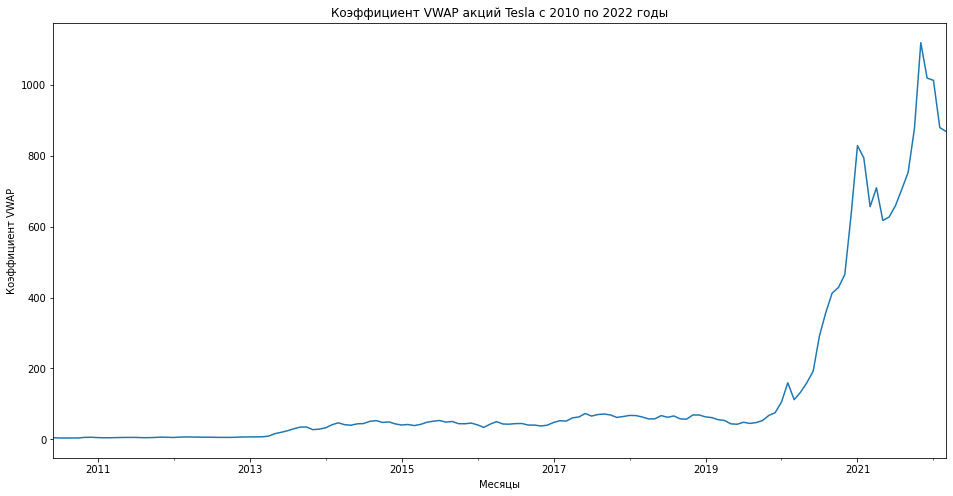

In [8]:
#построем график на основании среднемесячного VWAP
ax = stocks_data.plot(figsize = (16, 8), legend = None)
ax.set(title = 'Коэффициент VWAP акций Tesla с 2010 по 2022 годы', xlabel = 'Месяцы', ylabel = 'Коэффициент VWAP')

In [9]:
#разобьем данные на обучающую и тестовую выборки
#в роли обучающей выборки будут данные до марта 2021 года включительно
#в роли тестовой выборки будут данные с марта 2021 года до марта 2022 (год от последней записи в датасете)
train = stocks_data[:'2021-03']
test = stocks_data['2021-03':]

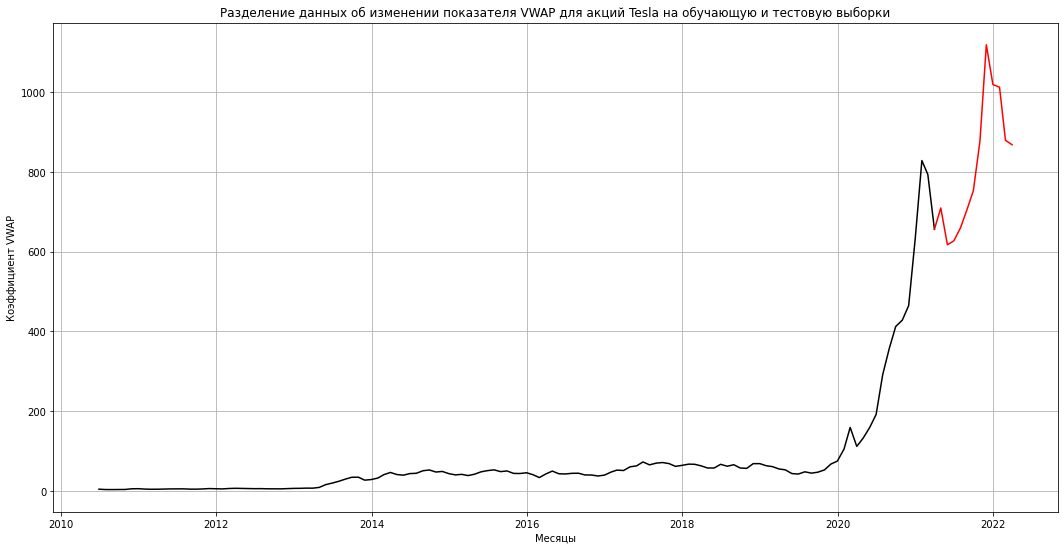

In [10]:
#отобразим разделение на графике
from pylab import rcParams
rcParams['figure.figsize'] = 18, 9
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.title('Разделение данных об изменении показателя VWAP для акций Tesla на обучающую и тестовую выборки')
plt.ylabel('Коэффициент VWAP')
plt.xlabel('Месяцы')
plt.grid()
plt.show()

In [11]:
steps = 6 #число шагов (размер окна) - гиперпараметр из прошлой работы

## Тестирование имеющейся модели

In [12]:
#получим x и y части как для обучающей, так и для контрольной выборки
x_train, y_train = split_data_by_steps(train, steps)
x_test, y_test = split_data_by_steps(test, steps)

In [13]:
#загрузим модель, полученную в прошлой работе
model = load_model('./models/initial_model')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 50)                350       
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


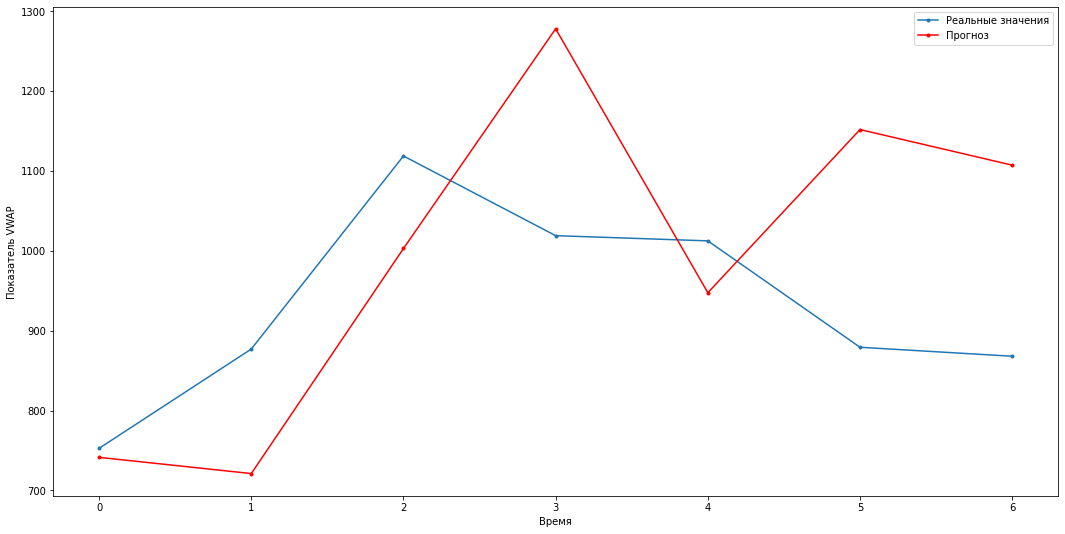

In [14]:
#прогноз на тестовой выборке
prediction = model.predict(x_test, verbose = 0)
plot_prediction(y_test, prediction)

5/5 [==============================] - 0s 4ms/step


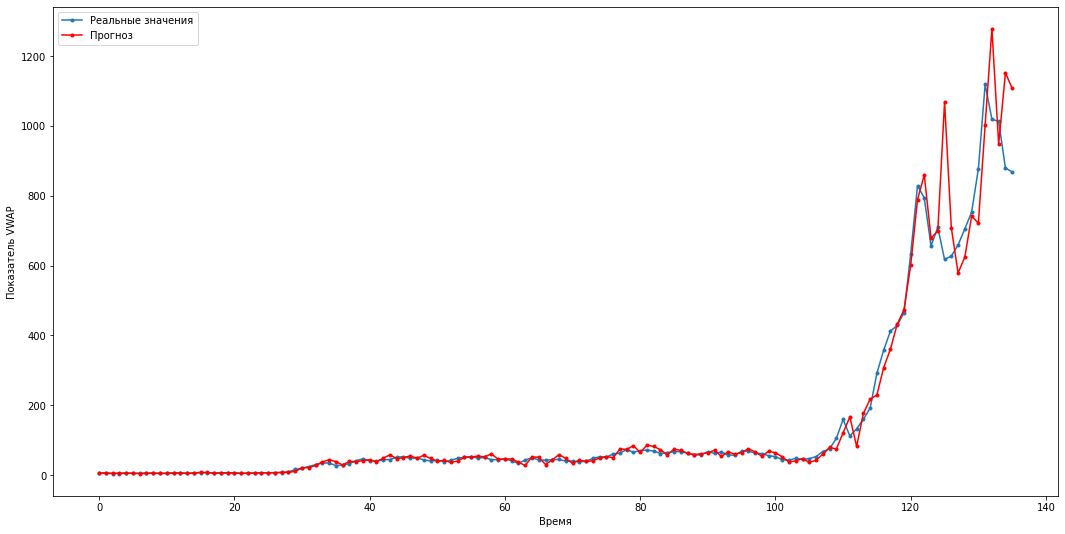

In [15]:
#прогноз на полной выборке
full_data, full_result = split_data_by_steps(stocks_data, steps)
full_prediction = model.predict(full_data)
plot_prediction(full_result, full_prediction)

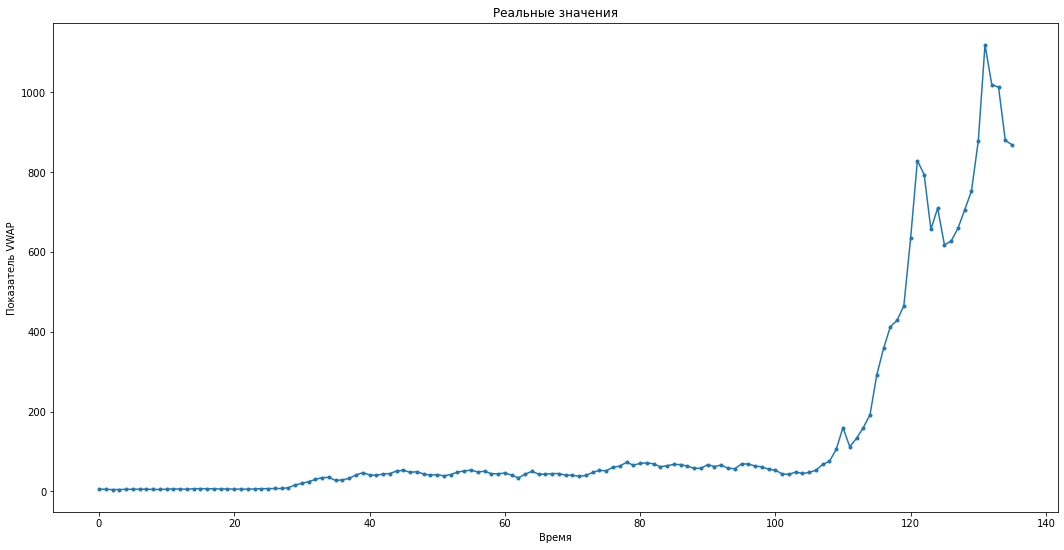

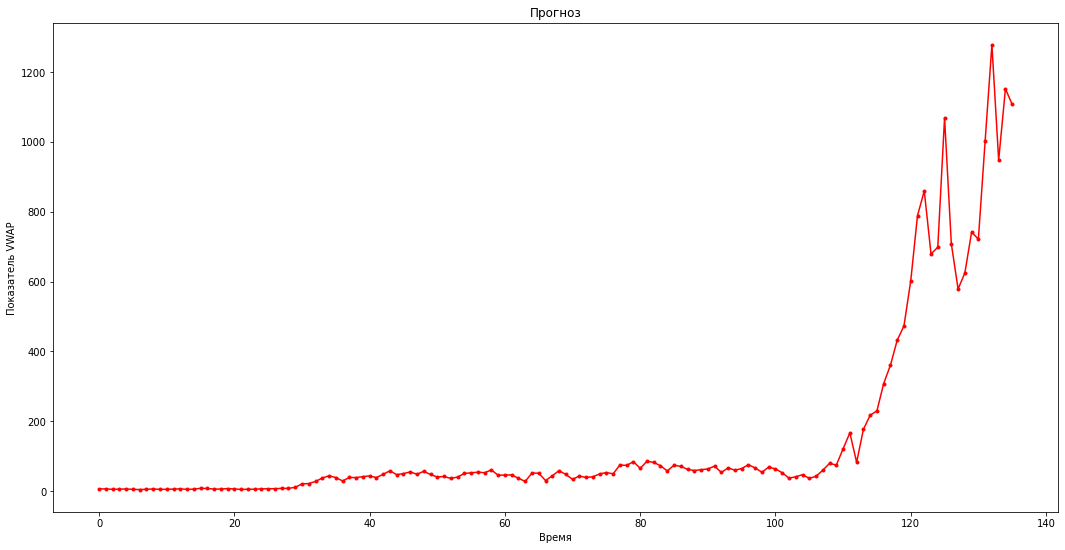

In [16]:
#графики по отдельности

#реальные значения
plt.title('Реальные значения')
plt.plot(full_result, marker='.', label="Реальные значения")
plt.ylabel('Показатель VWAP')
plt.xlabel('Время')
plt.show()

#прогноз
plt.title('Прогноз')
plt.plot(full_prediction, 'r', marker='.', label="Реальные значения")
plt.ylabel('Показатель VWAP')
plt.xlabel('Время')
plt.show()

In [17]:
#среднеквадратичная ошибка по итогу обучения на полной выборке
result_score = model.evaluate(full_data, full_result, verbose=0)
result_score

3629.47265625

In [19]:
#среднеквадратичная ошибка по итогу обучения на тестовой выборке
test_score = model.evaluate(x_train, y_train, verbose=0)
test_score

241.74562072753906

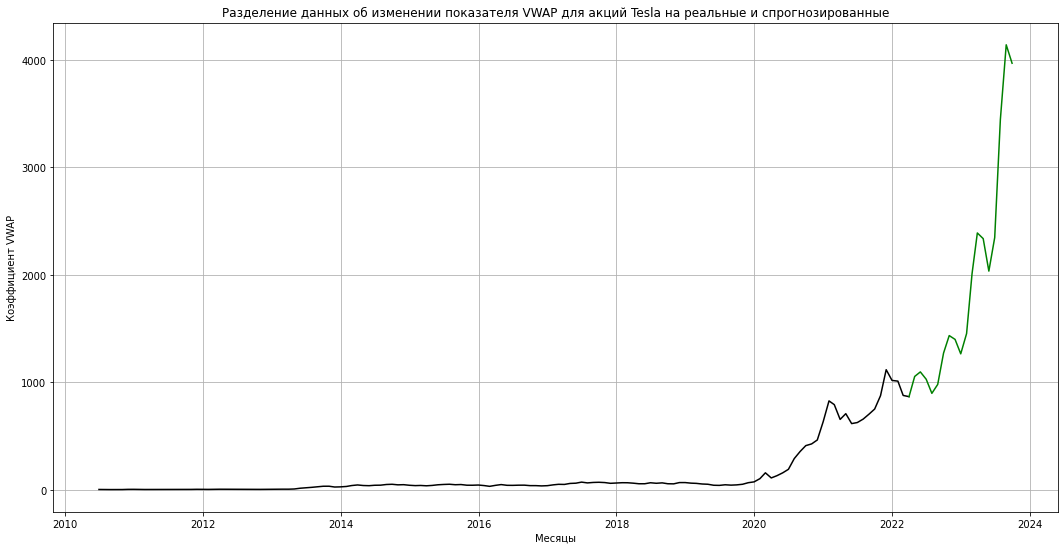

In [21]:
#получение и отображение dataframe с прогнозом
forecasted_result = forecast_and_plot(model=model, source=stocks_data, months_to_forecast=18, window_size=steps)

## Генетическое обучение сети

In [22]:
genetic_algorithm_inputs = full_data
genetic_algorithm_outputs = full_result

In [23]:
#гиперпараметры генетического алгоритма
generations_count = 20 #количество поколений
population_count = 16 #количество особей в одном поколении
mating_parents_count = 4 #количество родительских особей, дающих потомство для каждого поколения
keras_ga = pygad.kerasga.KerasGA(model=model,
                                 num_solutions=population_count) #инициализация начальной популяции
initial_population = keras_ga.population_weights #начальная популяция
crossover_probability = 0.8 #вероятность кроссинговера
crossover_type = "two_points" #тип кроссинговера
parent_selection_type = "sss" #тип селекции
updating_units_ratio = 0.8 #доля обновляемых особей
keep_parents = int((1 - updating_units_ratio) * population_count) #число родительских особей, переходящих в следующее поколение
mutation_type = "random" #тип мутации
mutation_probability = 0.1 #вероятность мутации
mutation_percent_genes = 10 #процент мутирующих генов

In [24]:
def callback_generation(ga_instance):
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))

In [25]:
#функция приспособленности (целевая функция) генетического алгоритма

def fitness_function(solution, solution_index):
    weights_matrix = pygad.kerasga.model_weights_as_matrix(model=model, weights_vector=solution)
    model.set_weights(weights_matrix)
    predictions = model.predict(genetic_algorithm_inputs)
    result_score = mean_squared_error(predictions, genetic_algorithm_outputs)
    print('MSE = ', result_score)
    fitness = 1.0 / result_score
    return fitness

In [26]:
genetic_algorithm = pygad.GA(num_generations=generations_count, 
                       num_parents_mating=mating_parents_count, 
                       initial_population=initial_population,
                       fitness_func=fitness_function,
                       on_generation=callback_generation)

In [27]:
genetic_algorithm.run()

5/5 [==============================] - 0s 2ms/step
MSE =  3629.4744391312956
5/5 [==============================] - 0s 3ms/step
MSE =  1287865.7014462107
5/5 [==============================] - 0s 3ms/step
MSE =  1565268.0653036765
5/5 [==============================] - 0s 3ms/step
MSE =  963089.0878660065
5/5 [==============================] - 0s 3ms/step
MSE =  5544.524533673007
5/5 [==============================] - 0s 2ms/step
MSE =  8902423.664697025
5/5 [==============================] - 0s 2ms/step
MSE =  1009575.9285443636
5/5 [==============================] - 0s 5ms/step
MSE =  1569526.4765497756
5/5 [==============================] - 0s 3ms/step
MSE =  1457058.895045931
5/5 [==============================] - 0s 3ms/step
MSE =  526458.8686790434
5/5 [==============================] - 0s 2ms/step
MSE =  6683281.963166855
5/5 [==============================] - 0s 2ms/step
MSE =  156755.7015098573
5/5 [==============================] - 0s 2ms/step
MSE =  1999020.958619591
5/5 [==

5/5 [==============================] - 0s 2ms/step
MSE =  8576.408127509876
5/5 [==============================] - 0s 2ms/step
MSE =  37932.02725822917
5/5 [==============================] - 0s 2ms/step
MSE =  320914.96190732915
5/5 [==============================] - 0s 2ms/step
MSE =  26289.22641788388
5/5 [==============================] - 0s 3ms/step
MSE =  174999.9307532203
5/5 [==============================] - 0s 2ms/step
MSE =  83501.39001264222
5/5 [==============================] - 0s 2ms/step
MSE =  304252.2766898365
5/5 [==============================] - 0s 3ms/step
MSE =  10012.565697147009
5/5 [==============================] - 0s 2ms/step
MSE =  20029.96258465983
5/5 [==============================] - 0s 2ms/step
MSE =  6691.439318984579
5/5 [==============================] - 0s 2ms/step
MSE =  13248.364140903177
5/5 [==============================] - 0s 2ms/step
MSE =  406829.04059594753
5/5 [==============================] - 0s 2ms/step
MSE =  9320.337036889181
5/5 [===

5/5 [==============================] - 0s 2ms/step
MSE =  388016.73607197555
5/5 [==============================] - 0s 2ms/step
MSE =  787939.2097464788
5/5 [==============================] - 0s 2ms/step
MSE =  55493.888112162196
5/5 [==============================] - 0s 2ms/step
MSE =  9769.912925735343
5/5 [==============================] - 0s 3ms/step
MSE =  114073.84322537147
5/5 [==============================] - 0s 3ms/step
MSE =  189338.41141278893
5/5 [==============================] - 0s 1ms/step
MSE =  359112.8141110567
5/5 [==============================] - 0s 2ms/step
MSE =  112477.66315639223
5/5 [==============================] - 0s 2ms/step
MSE =  93966.95753621802
5/5 [==============================] - 0s 2ms/step
MSE =  38539.56551943399
5/5 [==============================] - 0s 2ms/step
MSE =  11537.72273227079
5/5 [==============================] - 0s 2ms/step
MSE =  176518.85125228082
5/5 [==============================] - 0s 3ms/step
MSE =  183219.6714989197
5/5 [=

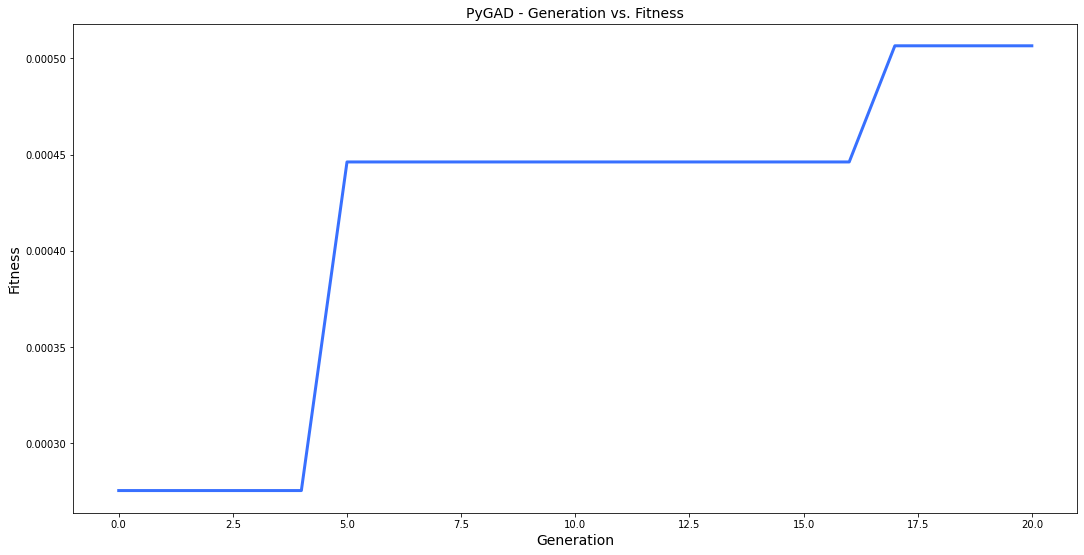

In [28]:
genetic_algorithm.plot_fitness()

In [30]:
#вывод информации о лучшей модели по итогу обучения
solution, solution_fitness, solution_idx = genetic_algorithm.best_solution()
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

5/5 [==============================] - 0s 3ms/step
MSE =  349032.1272200879
5/5 [==============================] - 0s 2ms/step
MSE =  654927.0762903792
5/5 [==============================] - 0s 2ms/step
MSE =  157080.2756155983
5/5 [==============================] - 0s 2ms/step
MSE =  17011.121629794645
5/5 [==============================] - 0s 2ms/step
MSE =  38250.38687348911
5/5 [==============================] - 0s 2ms/step
MSE =  652071.6050473368
5/5 [==============================] - 0s 2ms/step
MSE =  546080.1519329312
5/5 [==============================] - 0s 2ms/step
MSE =  33689.41664731747
5/5 [==============================] - 0s 2ms/step
MSE =  173192.50005005335
5/5 [==============================] - 0s 2ms/step
MSE =  75308.64143495211
5/5 [==============================] - 0s 2ms/step
MSE =  102685.00253053902
5/5 [==============================] - 0s 4ms/step
MSE =  288916.9548084166
5/5 [==============================] - 0s 3ms/step
MSE =  140096.2022025449
5/5 [====

In [31]:
#обновление модели в соответствии с результатом генетического алгоритма
best_solution_weights = pygad.kerasga.model_weights_as_matrix(model=model,
                                                              weights_vector=solution)
model.set_weights(best_solution_weights)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 50)                350       
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


## Проверка результата

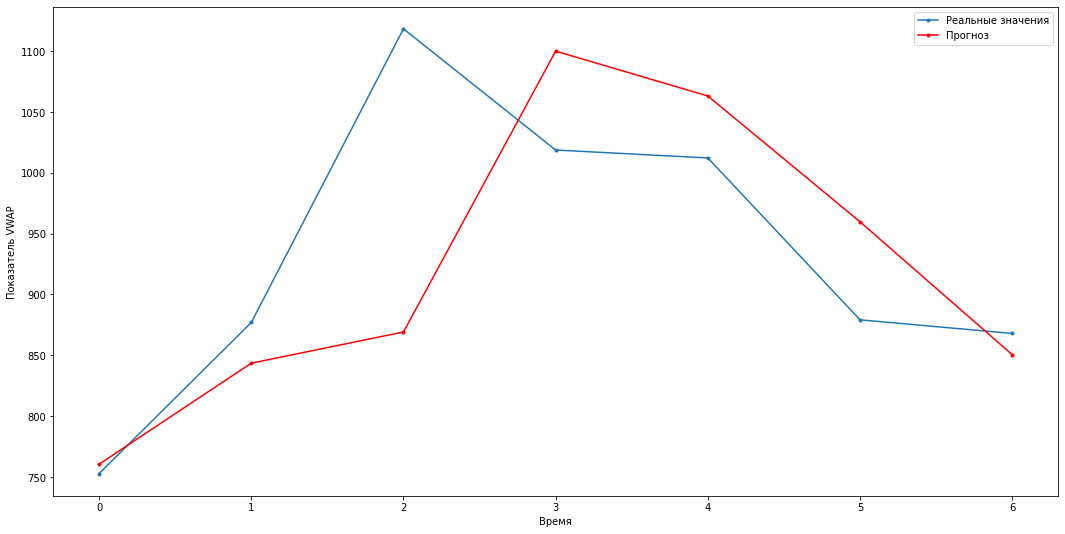

In [32]:
#прогноз на тестовой выборке
prediction = model.predict(x_test, verbose = 0)
plot_prediction(y_test, prediction)

5/5 [==============================] - 0s 2ms/step


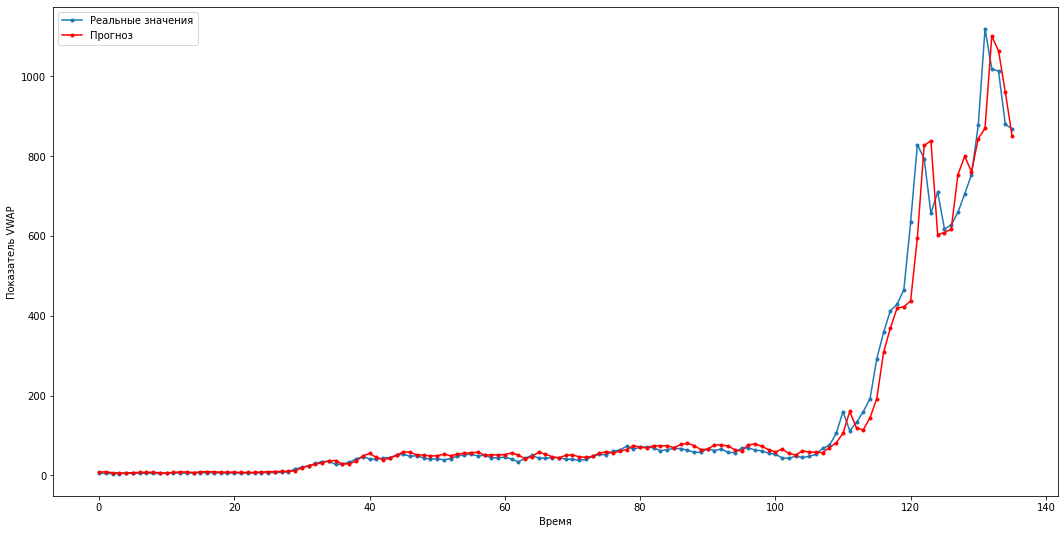

In [33]:
#прогноз на полной выборке
full_data, full_result = split_data_by_steps(stocks_data, steps)
full_prediction = model.predict(full_data)
plot_prediction(full_result, full_prediction)

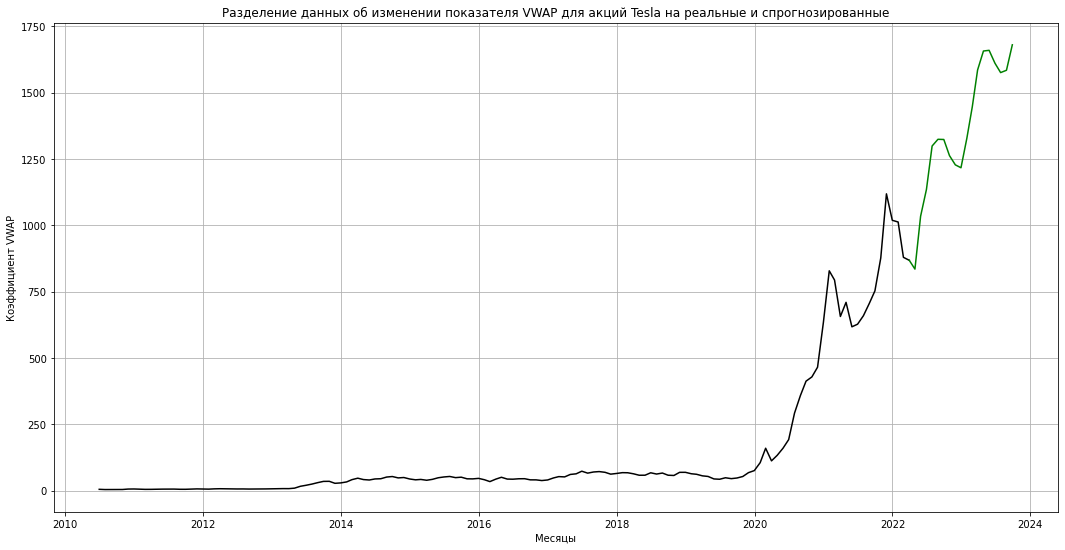

In [34]:
#получение и отображение dataframe с прогнозом
genetic_forecasted_result = forecast_and_plot(model=model, source=stocks_data, months_to_forecast=18, window_size=steps)

In [35]:
#среднеквадратичная ошибка по итогу обучения на полной выборке
result_score = model.evaluate(full_data, full_result, verbose=0)
result_score

1974.4267578125

In [37]:
#среднеквадратичная ошибка по итогу обучения на тестовой выборке
test_score = model.evaluate(x_train, y_train, verbose=0)
test_score

1288.793701171875

In [39]:
#сохраняем модель в формате h5
model_with_h5_name = f"result_model.h5"
model.save(f'./models/h5/results/{model_with_h5_name}')
print('Модель была успешно сохранена в формате h5')

Модель была успешно сохранена в формате h5


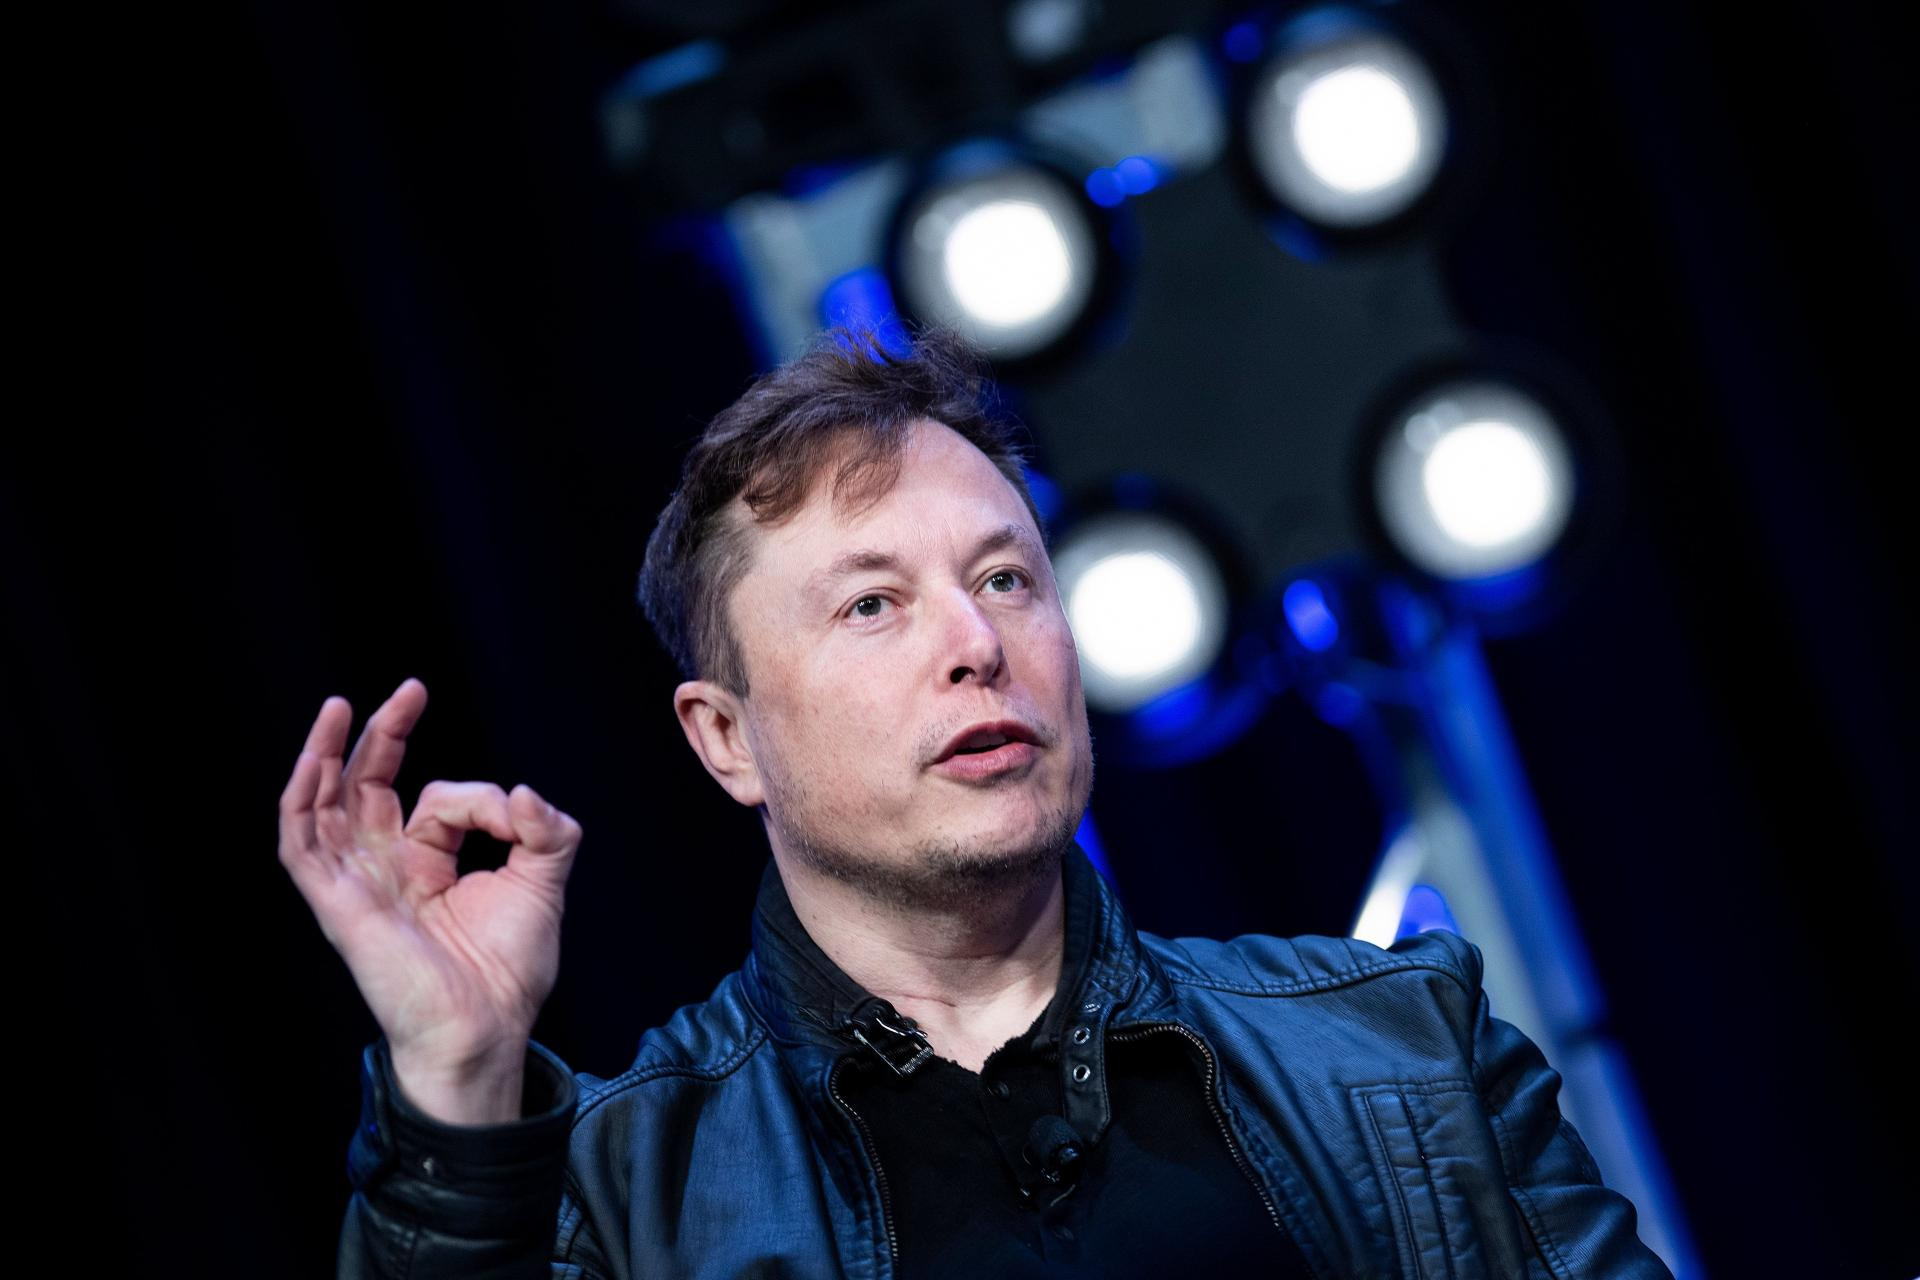